In [1]:
import openpyxl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
import datetime
import math
import pandas as pd
from scipy import stats
import seaborn as sn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Drops specific values in a dataframe
# if flag = 1, drops values less than 'val'
# if flag = 0, drops values greater than 'val'
def drop_values(dataframe, column, val, flag):
    if flag:
        return dataframe.drop(dataframe[column < val].index)
    else:
        return dataframe.drop(dataframe[column > val].index)
    
# Normalize the data
def norm(dataframe):
    return (dataframe - dataframe.describe().transpose()['mean'] / dataframe.describe().transpose()['std'])

# Air Quality Health Factor Function
# Pass NO2 concentration in ppb
# Pass O3 concentration in ppb
# Pass PM2.5 concentration in ug/m^3
def AQHI(NO2, O3, PM25):
    NO2_CONST = 0.000871
    O3_CONST = 0.000537
    PM25_CONST = 0.000487
    return((10/10.4)*100*(np.exp(NO2_CONST*NO2)-1+np.exp(O3_CONST*O3)-1+np.exp(PM25_CONST*PM25_CONST)-1))

# Remove outliers
def remove_outliers(dataframe):
    return dataframe[(np.abs(stats.zscore(dataframe)) < 3).all(axis=1)]
    
# MAKE THE CLUSTER DATAFRAME
dataframe = pd.read_pickle('pkl_datasets/CLUSTER_DATASET_3h.pkl')
# Remove the outliers in the columns of the dataframe
dataframe = remove_outliers(dataframe)
dataframe

,Temperature[degC],Humidity[percent],PM1.0[ug/m^3],PM2.5[ug/m^3],PM10.0[ug/m^3],O3[ppb],O3[V],NO2[ppb],NO2[V],Pressure[Pa],NO,NO2,NOx,O3,PM10_conc,PM10-2.5_conc,PM2.5_conc,Air_Temperature,Relative_Humidity
Timestamp,,,,,,,,,,,,,,,,,,,
2020-05-06 15:00:00,21.946500,19.130500,1.273519,2.095370,2.294074,52.676741,1.424328,137.660204,1.421998,99146.838148,1.545667,3.924000,5.473000,40.524667,16.071667,11.776333,4.292000,12.503000,27.429667
2020-05-06 18:00:00,16.114352,23.103056,1.813889,2.737778,2.967963,52.129667,1.423875,88.061111,1.422065,99165.178704,1.449333,7.310000,8.586333,37.520000,16.953333,12.431000,4.526667,11.368667,27.824000
2020-05-06 21:00:00,11.595500,26.795481,0.715556,1.262037,1.406852,50.124519,1.423596,67.996130,1.422025,99232.284074,0.421333,4.503333,4.969667,35.328333,9.030000,5.742000,3.288667,8.400667,29.792333
2020-05-07 00:00:00,9.611278,31.528685,4.110926,5.190556,5.582037,50.093222,1.423499,65.919889,1.421995,99116.492778,0.373333,7.564000,7.937000,30.056000,8.662333,4.973667,3.689667,6.681000,34.929333
2020-05-07 03:00:00,8.166315,33.071926,6.222963,8.163704,8.433889,50.517481,1.423422,66.344741,1.421963,99012.199074,0.699333,11.680333,12.584000,25.259000,8.444000,4.921667,3.518667,5.196000,36.994000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-11 00:00:00,22.092648,70.038093,2.772222,4.476852,4.904630,56.960056,1.424244,152.554889,1.421863,98416.097222,0.485667,11.085000,11.758000,42.265667,10.642000,5.479667,5.162000,17.833667,91.955000
2020-06-11 03:00:00,21.786611,67.208648,2.918704,4.334259,4.705185,52.303315,1.424316,147.138556,1.421887,98462.187778,0.179667,5.566000,5.746000,39.194333,18.091667,12.397667,5.695000,18.010333,85.373667
2020-06-11 06:00:00,22.033019,55.905926,0.859074,1.169630,1.297778,38.324741,1.424623,128.527815,1.422034,98798.015556,0.855000,3.981333,4.831000,18.223333,14.051000,11.068000,2.985333,17.485333,70.401333


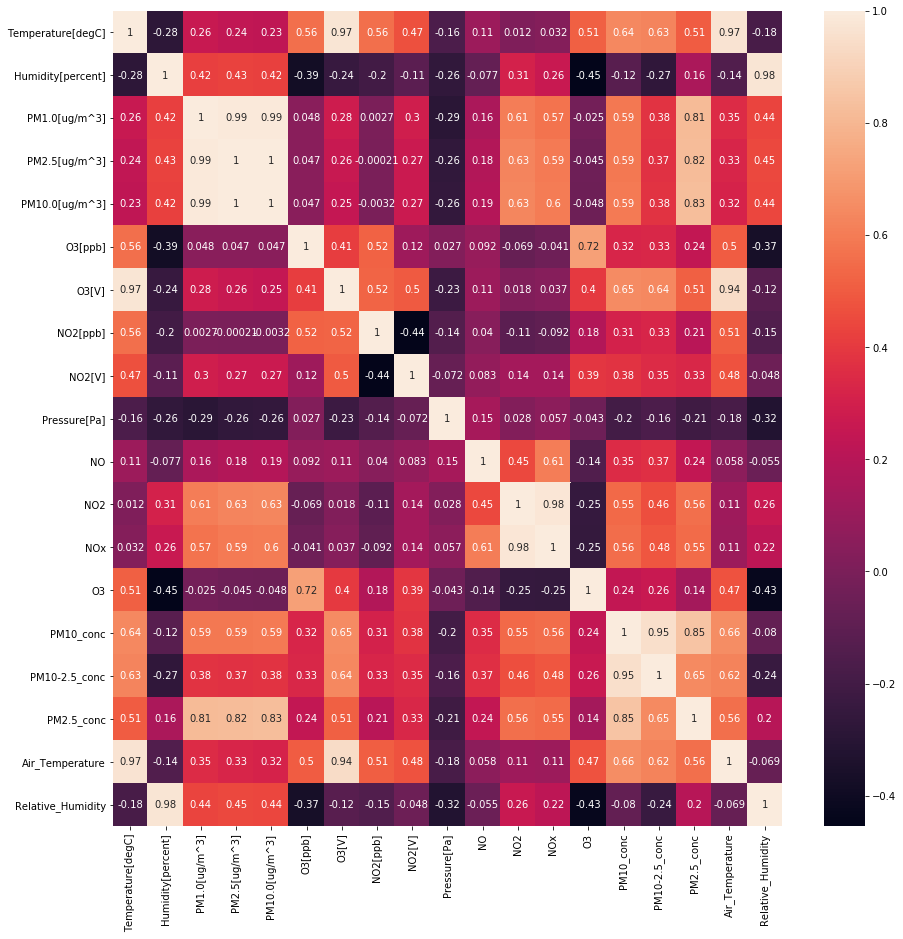

In [2]:
corrMatrix = dataframe.corr()
plt.subplots(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True)
plt.show()

0.9407582542722169

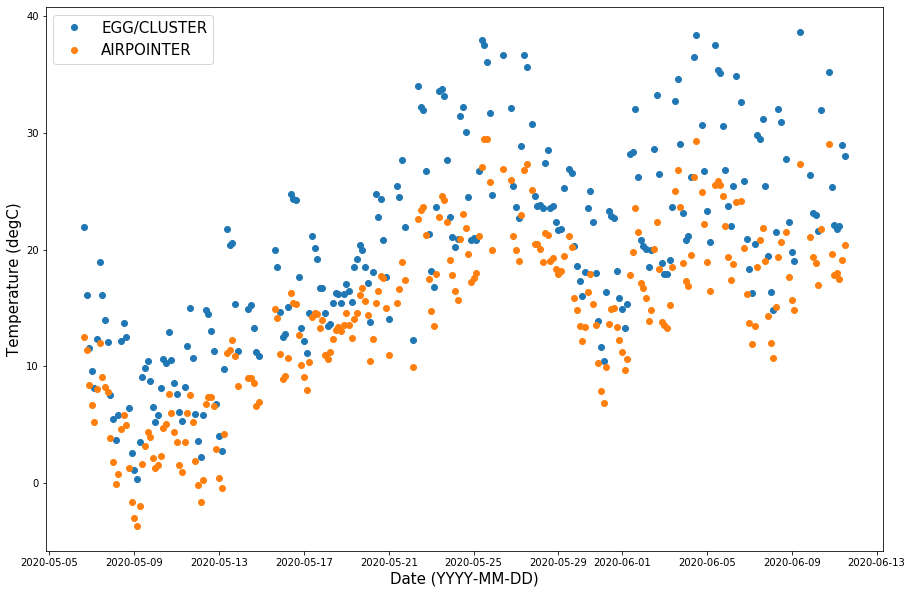

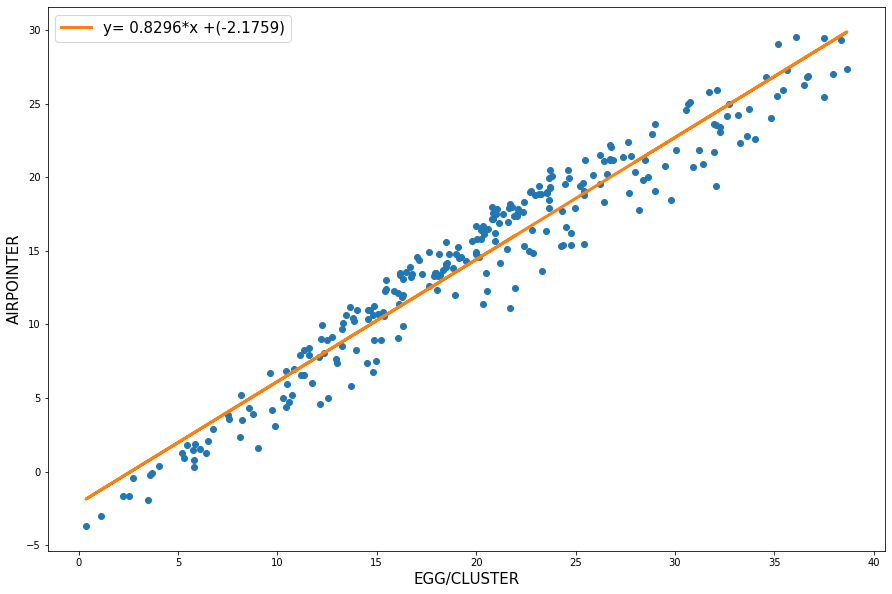

In [3]:
# ----------------------------- TEMPERATURE FROM CLUSTER vs. AIR_TEMPERATURE FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(dataframe.index.to_series(), dataframe['Temperature[degC]'], 'o', label="EGG/CLUSTER")
plt.plot(dataframe.index.to_series(), dataframe['Air_Temperature'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('Temperature (degC)', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = dataframe['Temperature[degC]'].to_numpy()
# Airpointer
yValues = dataframe['Air_Temperature'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

0.9522164854453973

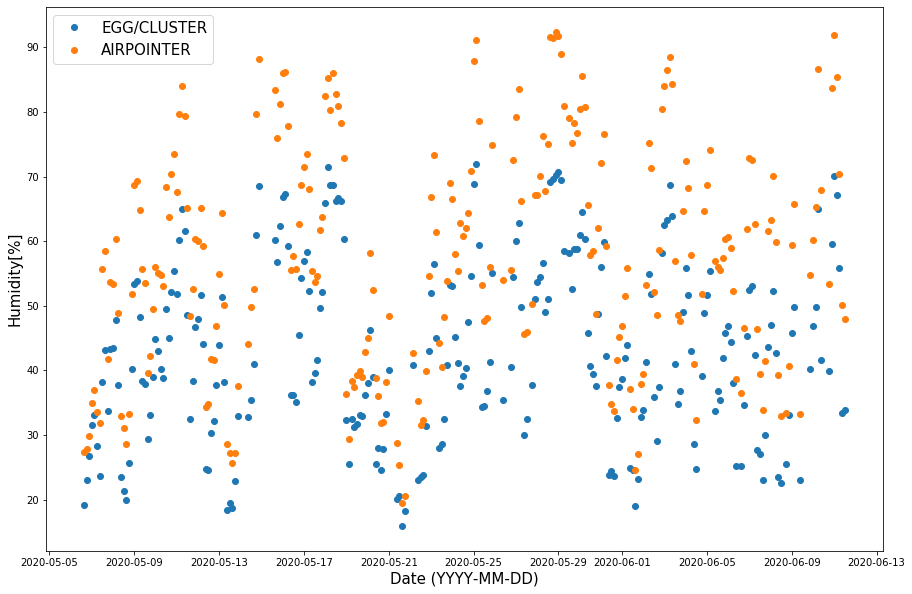

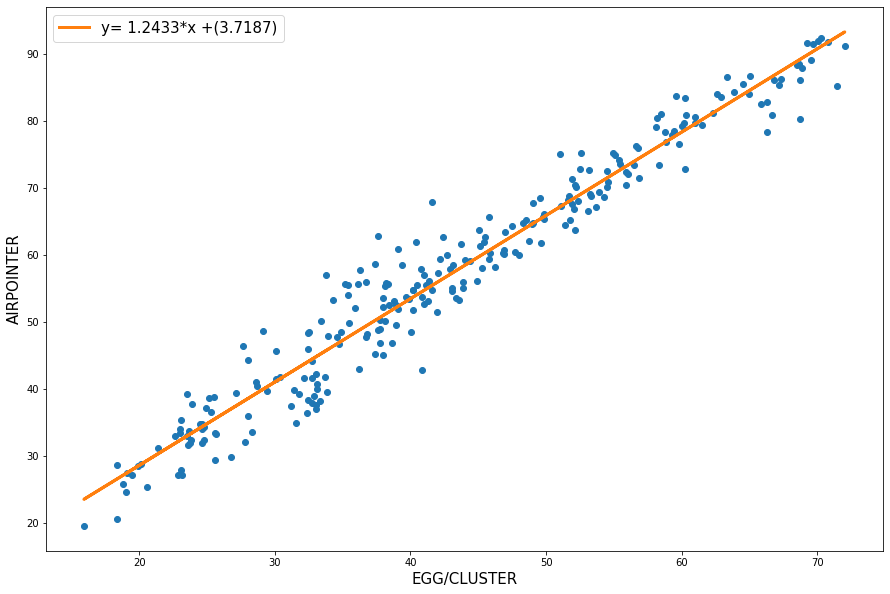

In [4]:
# ----------------------------- HUMIDITY FROM CLUSTER vs. HUMIDITY FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(dataframe.index.to_series(), dataframe['Humidity[percent]'], 'o', label="EGG/CLUSTER")
plt.plot(dataframe.index.to_series(), dataframe['Relative_Humidity'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('Humidity[%]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = dataframe['Humidity[percent]'].to_numpy()
# Airpointer
yValues = dataframe['Relative_Humidity'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

0.6784372934032235

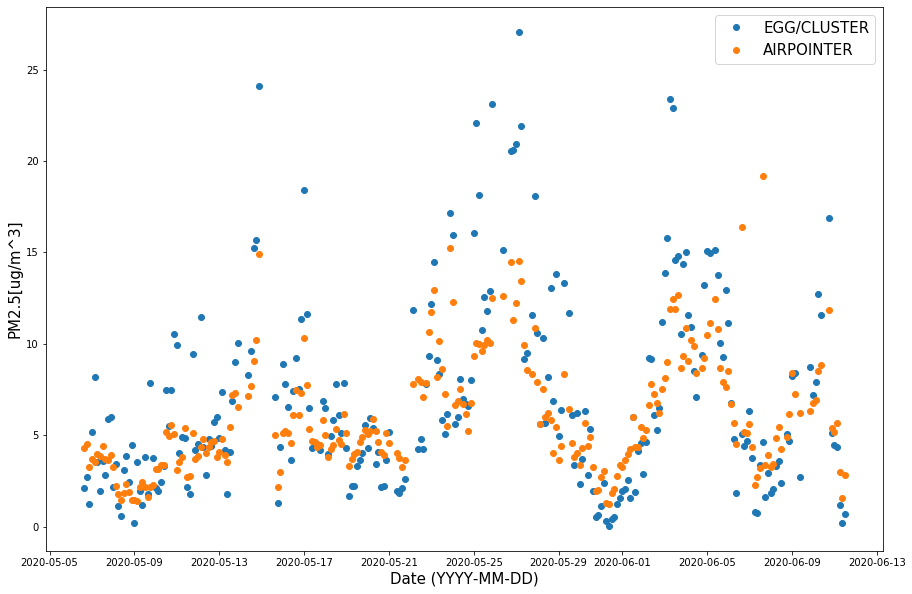

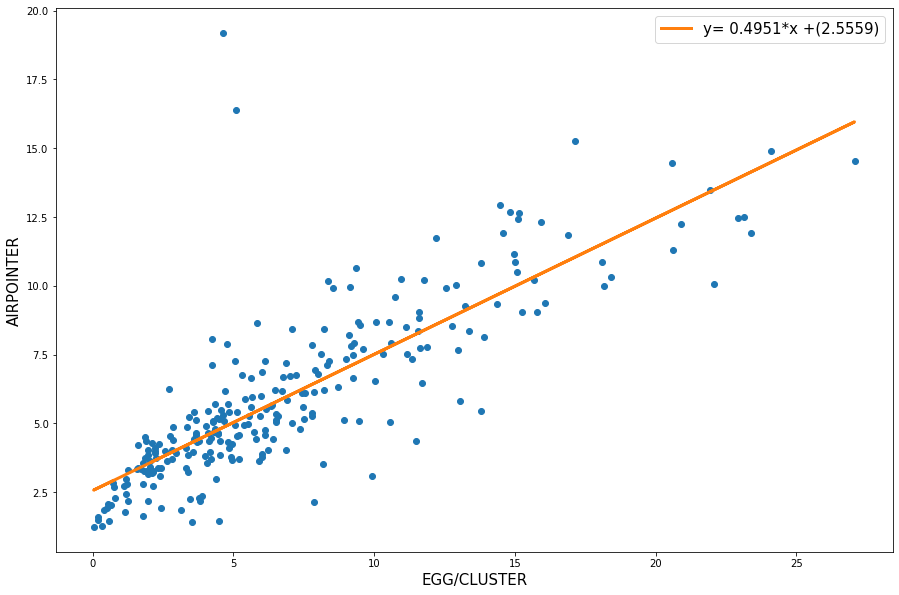

In [5]:
# ----------------------------- PM2.5 FROM CLUSTER vs. PM2.5 FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(dataframe.index.to_series(), dataframe['PM2.5[ug/m^3]'], 'o', label="EGG/CLUSTER")
plt.plot(dataframe.index.to_series(), dataframe['PM2.5_conc'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('PM2.5[ug/m^3]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = dataframe['PM2.5[ug/m^3]'].to_numpy()
# Airpointer
yValues = dataframe['PM2.5_conc'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1))) 

0.35290237907144295

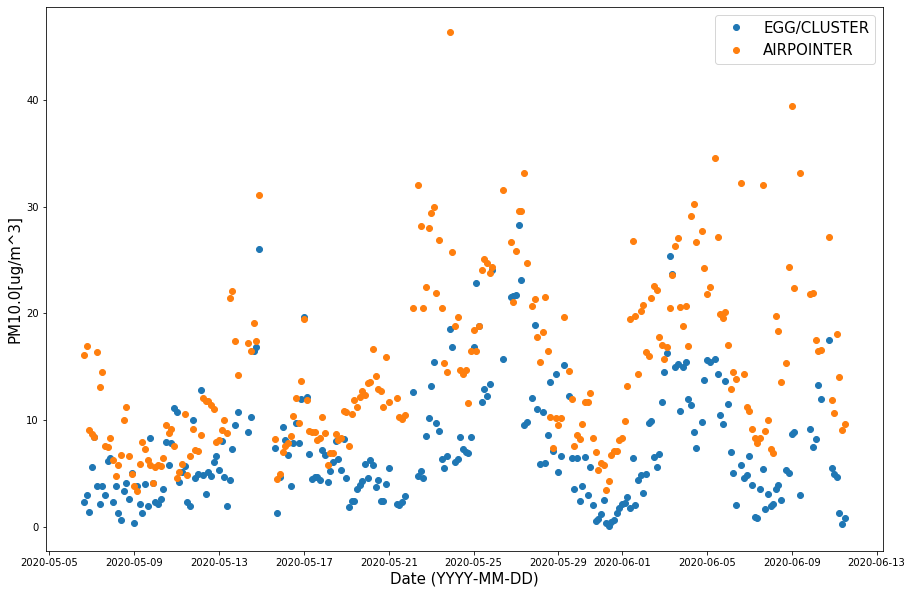

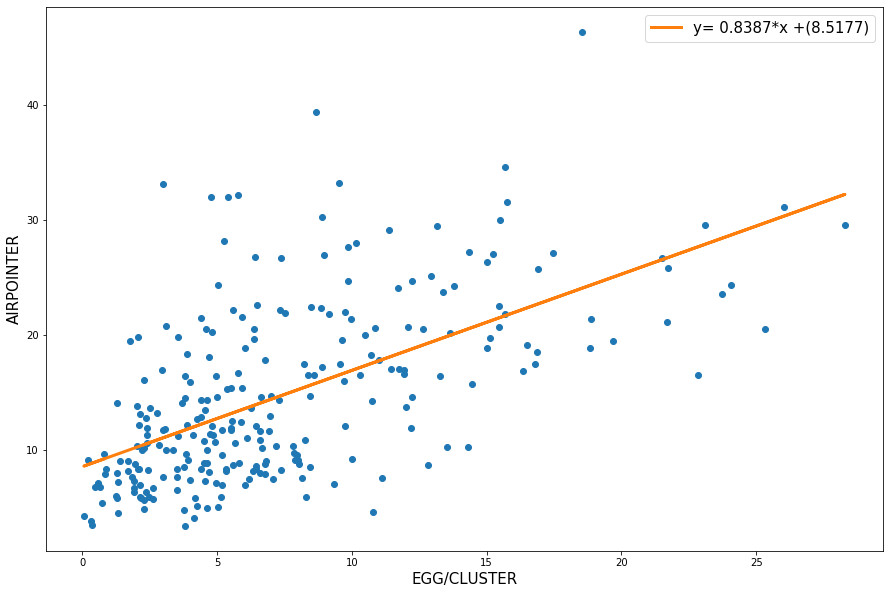

In [6]:
# ----------------------------- PM10.0 FROM CLUSTER vs. PM10.0 FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(dataframe.index.to_series(), dataframe['PM10.0[ug/m^3]'], 'o', label="EGG/CLUSTER")
plt.plot(dataframe.index.to_series(), dataframe['PM10_conc'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('PM10.0[ug/m^3]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = dataframe['PM10.0[ug/m^3]'].to_numpy()
# Airpointer
yValues = dataframe['PM10_conc'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

0.5184383686450071

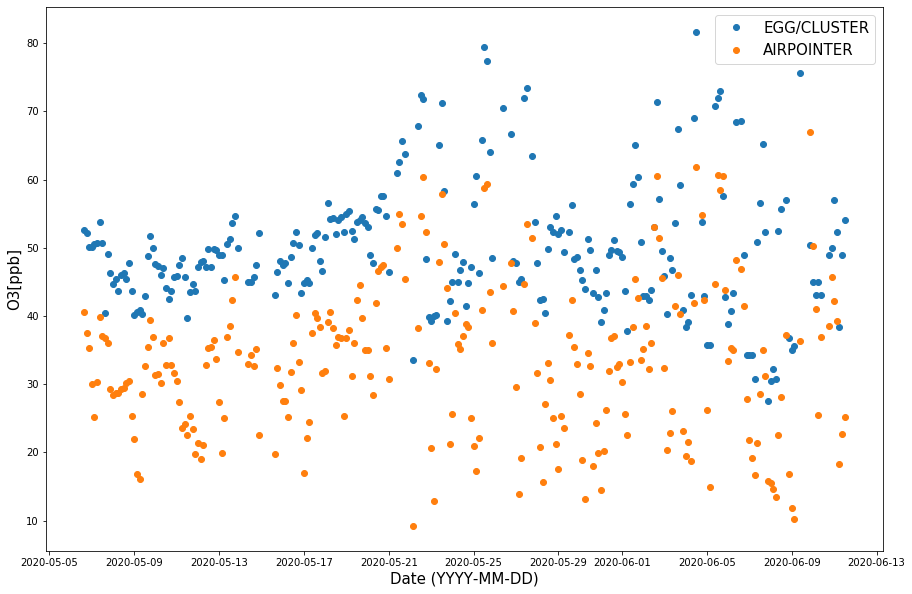

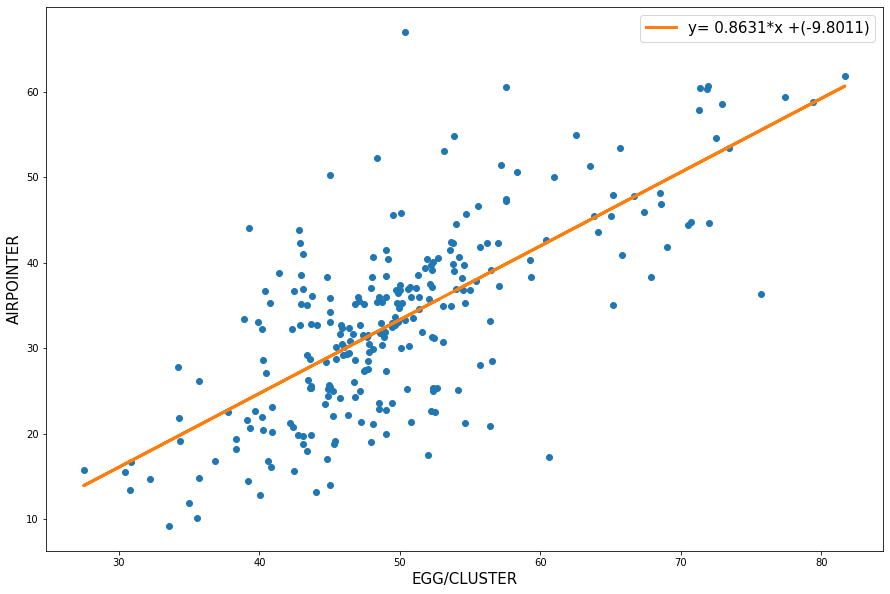

In [7]:
# ----------------------------- O3 (OZONE) FROM CLUSTER vs. O3 (OZONE) FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(dataframe.index.to_series(), dataframe['O3[ppb]'], 'o', label="EGG/CLUSTER")
plt.plot(dataframe.index.to_series(), dataframe['O3'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('O3[ppb]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = dataframe['O3[ppb]'].to_numpy()
# Airpointer
yValues = dataframe['O3'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1))) 

0.26813294825597256

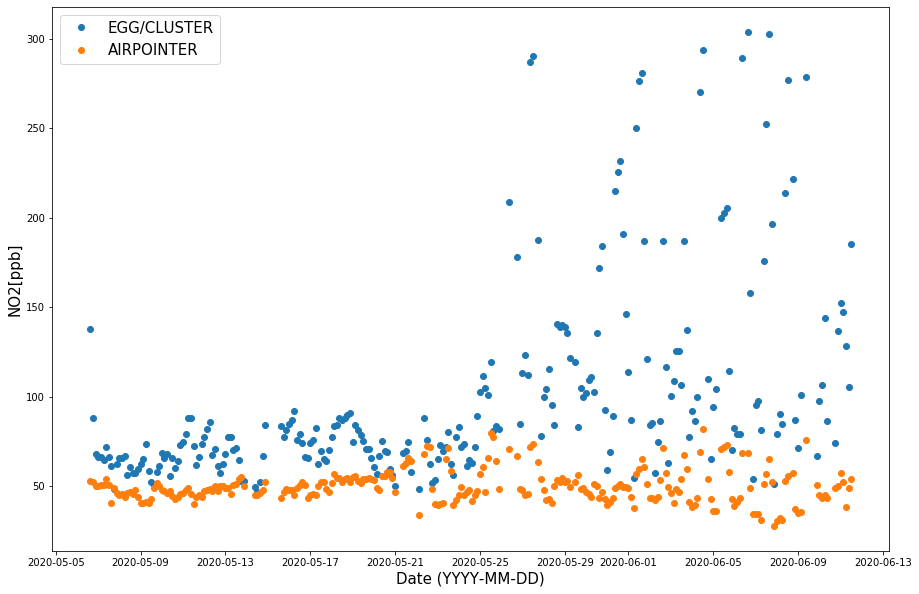

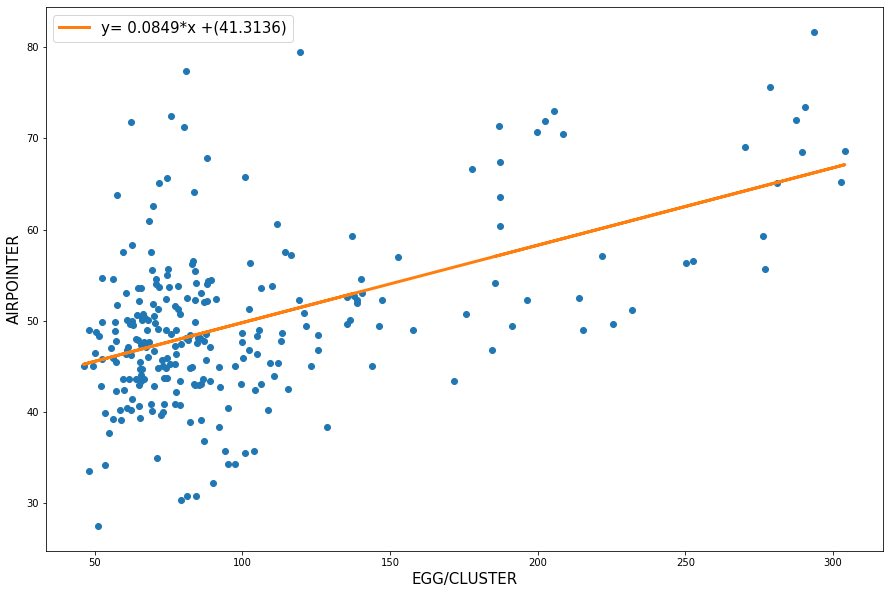

In [8]:
# ----------------------------- NO2 FROM CLUSTER vs. O3 FROM CLUSTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(dataframe.index.to_series(), dataframe['NO2[ppb]'], 'o', label="EGG/CLUSTER")
plt.plot(dataframe.index.to_series(), dataframe['O3[ppb]'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2[ppb]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = dataframe['NO2[ppb]'].to_numpy()
# Airpointer
yValues = dataframe['O3[ppb]'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

0.012705106063802485

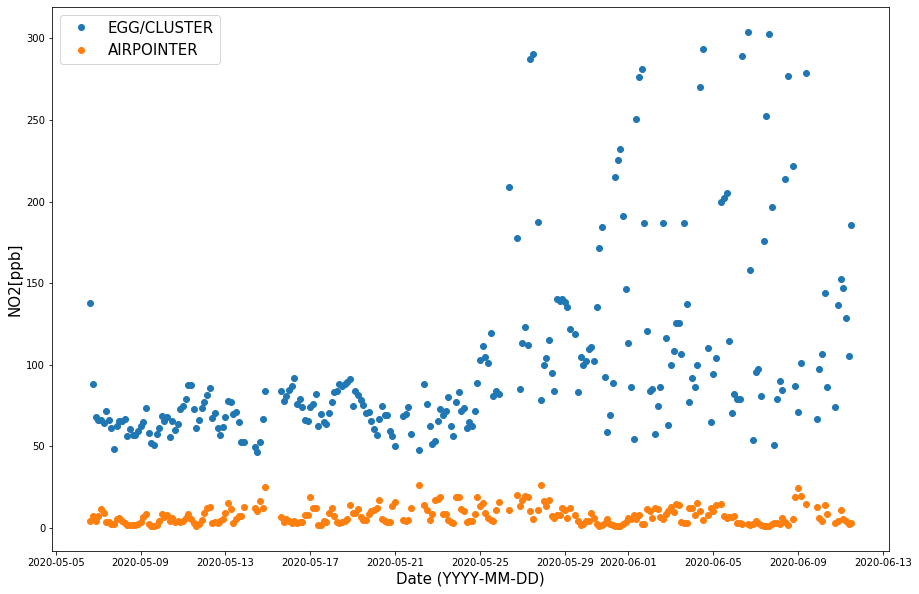

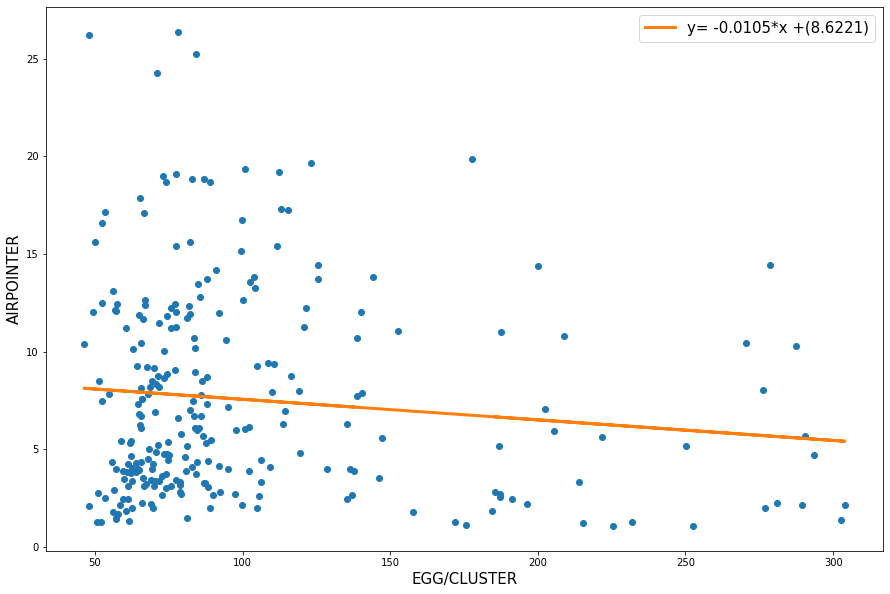

In [9]:
# ----------------------------- NO2 FROM CLUSTER vs. NO2 FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(dataframe.index.to_series(), dataframe['NO2[ppb]'], 'o', label="EGG/CLUSTER")
plt.plot(dataframe.index.to_series(), dataframe['NO2'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2[ppb]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = dataframe['NO2[ppb]'].to_numpy()
# Airpointer
yValues = dataframe['NO2'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))